In [78]:
# import argparse
import os
import pickle
# import time
# from itertools import product
# from math import inf, pi

import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import jax.debug as jdb
from functools import partial
import numpy as np

from tqdm.auto import tqdm

# from dynamics import prior, disturbance, plant
# from utils import params_to_posdef
from utils import random_ragged_spline, spline
from utils import (tree_normsq, rk38_step, epoch,   # noqa: E402
                   odeint_fixed_step, odeint_ckpt, random_ragged_spline, spline,
            params_to_cholesky, params_to_posdef, vee, hat,
            
            quaternion_to_rotation_matrix, flat_rotation_matrix_to_quaternion, 
            quaternion_multiply)

# from functools import partial
import matplotlib.pyplot as plt
# import csv

plt.rcParams.update({'font.size': 24})

In [79]:
# trial_name = 'hardware_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_reg_P_1e-2'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.0100.pkl'
# trial_name = 'hardware_mac_kR_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'hardware_mac_kR_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'hardware_mac_kR_reg_P_100'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'hardware_ubuntu_kR_reg_P_500'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=500.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_1e-1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_1'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=1.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=10.0000.pkl'
# trial_name = 'hardware_ubuntu_smallP_reg_P_100'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=100.0000.pkl'
# trial_name = 'hardware_10'
# filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'
trial_name = 'hardware_11'
filename = 'seed=0_M=50_E=1000_pinit=2.00_pfreq=2000_regP=0.1000.pkl'

pkl = f'{trial_name}/{filename}'
with open(f'train_results/{pkl}', 'rb') as file:
    raw = pickle.load(file)

best epoch: 2
eigs_P: [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001]
eigs_Λ: [0.79421747 1.282099   0.83737403]
eigs_K: [0.7034042  0.7836556  0.61369586]


(Array(3.2663424, dtype=float32),
 Array(3.2498937, dtype=float32),
 Array(0.01644454, dtype=float32),
 Array(3.2000005e-06, dtype=float32))

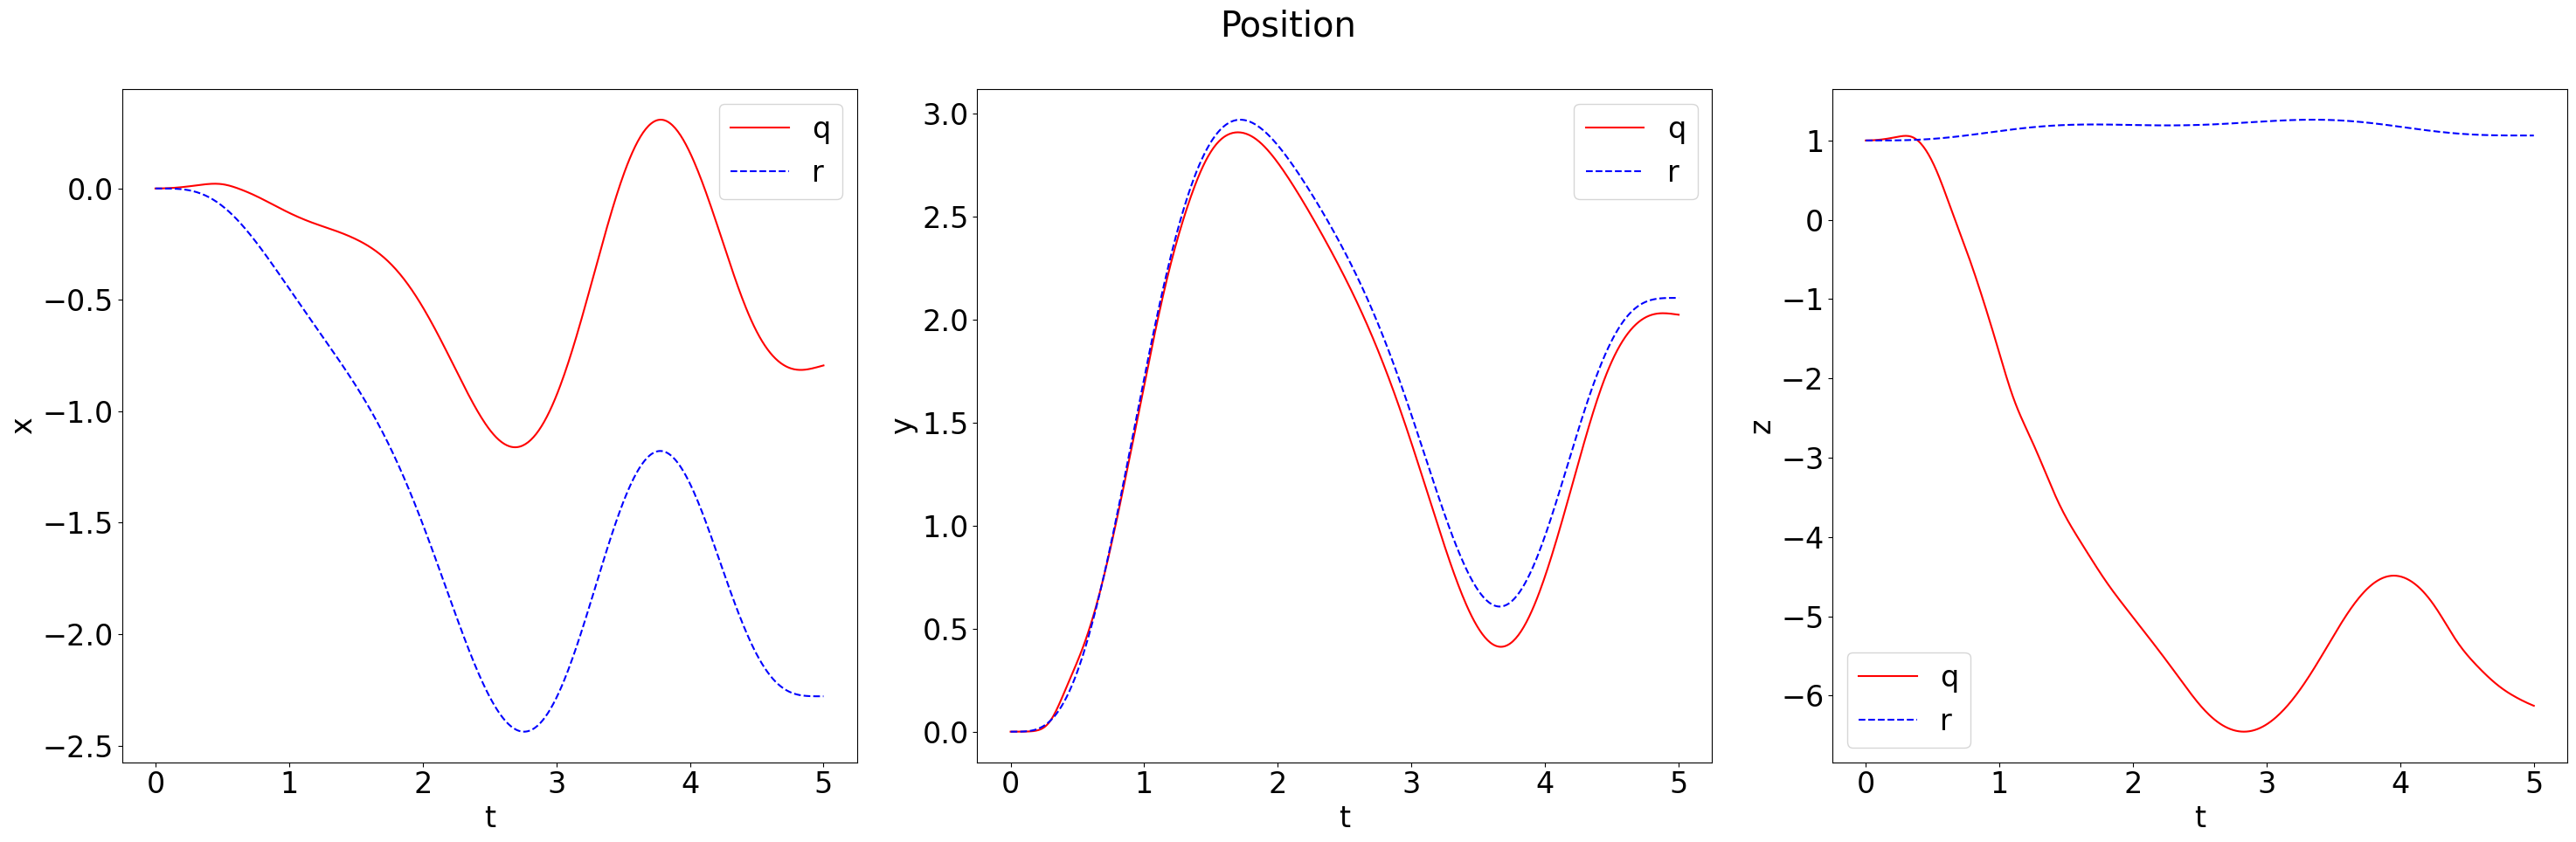

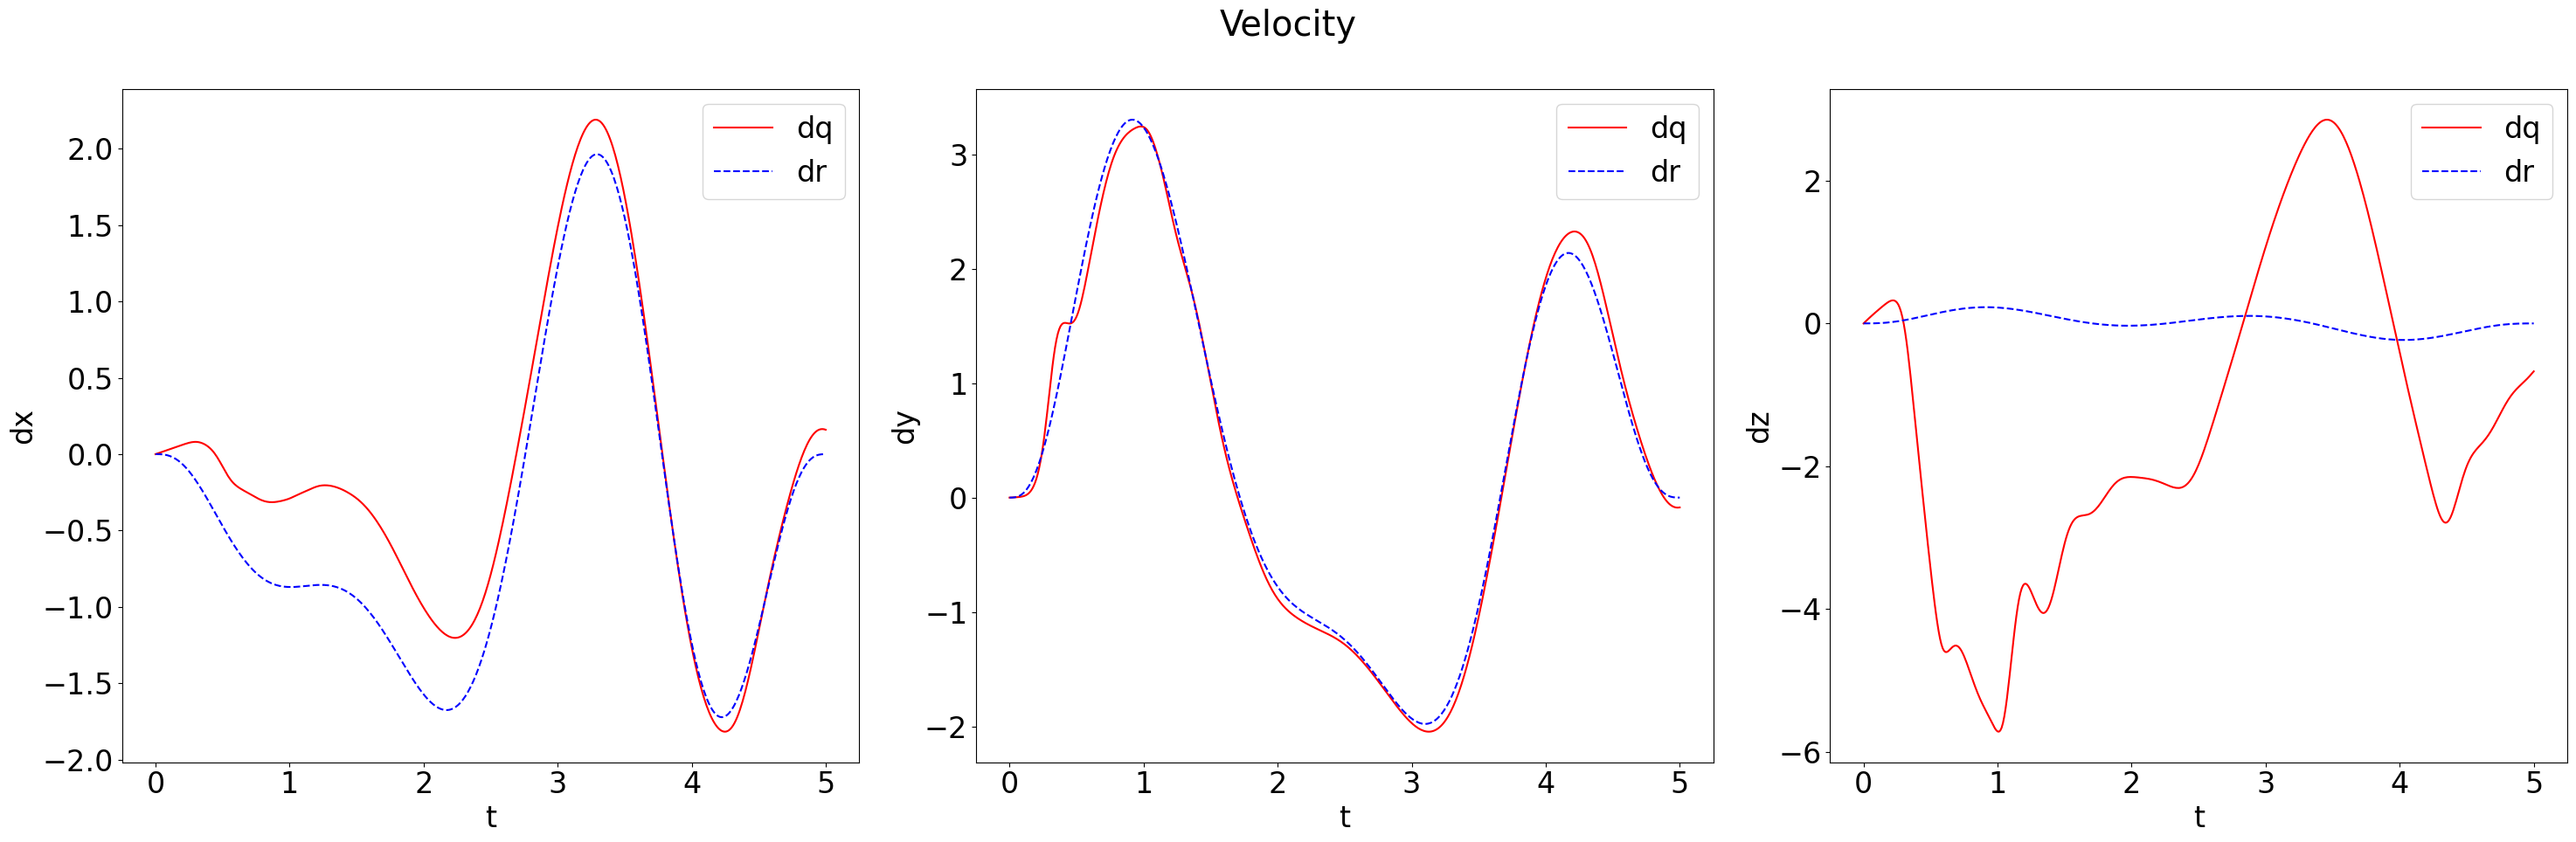

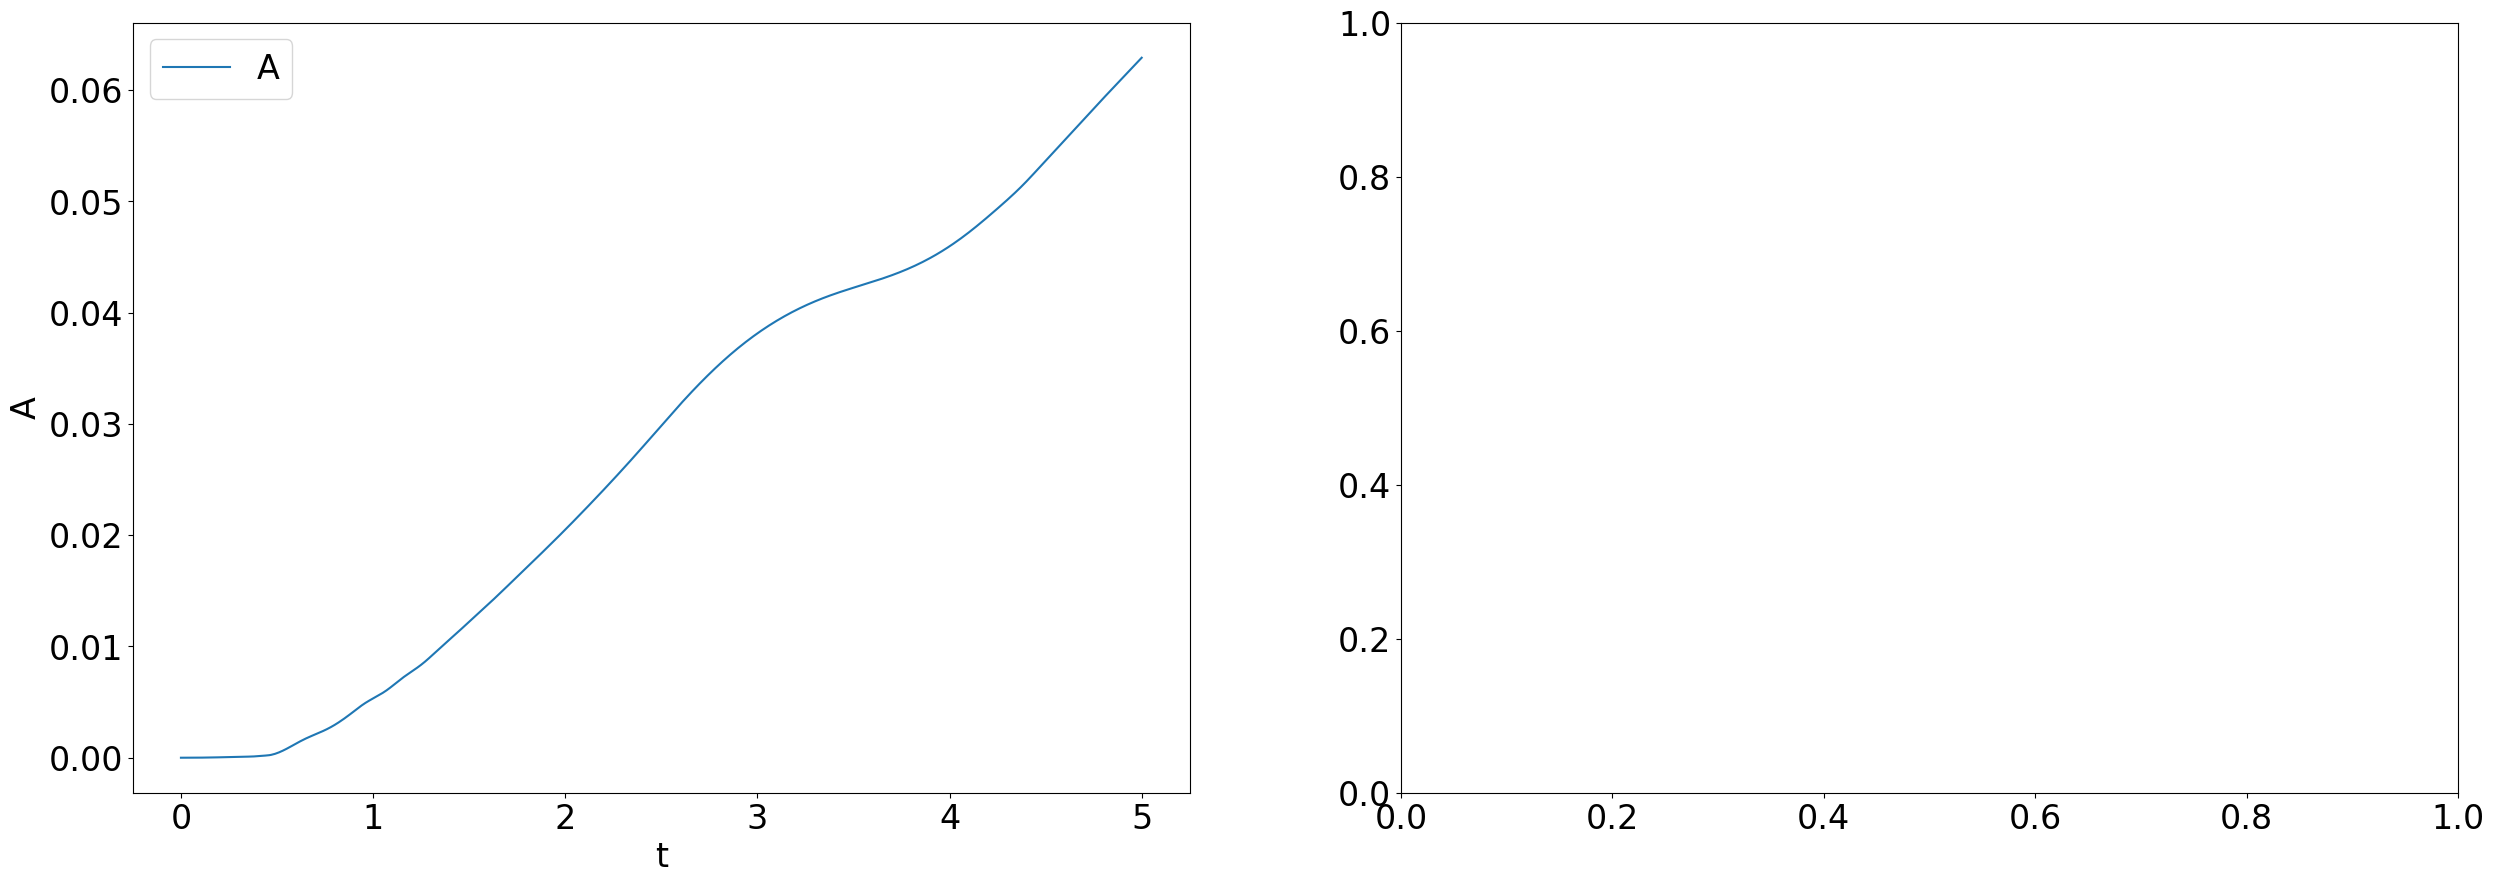

In [90]:
# mystery_i = 0
# for k,v in raw['train_lossaux_history'][epoch_i].items():
#     if type(v) is list or type(v) is tuple:
#         for i in v:
#             print(k, i.shape)
#     else:
#         print(k, v.shape)

def validate_model(raw, epoch_i, print_=False, plot=False):
    hparams = raw['hparams']
    dt = hparams['meta']['dt']
    T = hparams['meta']['T']
    num_refs = hparams['meta']['num_refs']
    coefs = raw['coefs']
    max_ref = raw['max_ref']
    min_ref = raw['min_ref']
    t_knots = raw['t_knots']

    A = raw['train_lossaux_history'][epoch_i]['A']
    W = raw['train_lossaux_history'][epoch_i]['W']
    b = raw['train_lossaux_history'][epoch_i]['b']
    eigs_K = raw['train_lossaux_history'][epoch_i]['eigs_K']
    eigs_P = raw['train_lossaux_history'][epoch_i]['eigs_P']
    eigs_Λ = raw['train_lossaux_history'][epoch_i]['eigs_Λ']
    control_loss = raw['train_lossaux_history'][epoch_i]['control_loss']
    estimation_loss = raw['train_lossaux_history'][epoch_i]['estimation_loss']
    tracking_loss = raw['train_lossaux_history'][epoch_i]['tracking_loss']
    l2_penalty = raw['train_lossaux_history'][epoch_i]['l2_penalty']
    reg_P_penalty = raw['train_lossaux_history'][epoch_i]['reg_P_penalty']
    pnorm = raw['train_lossaux_history'][epoch_i]['pnorm']
    x = raw['train_lossaux_history'][epoch_i]['x']

    reg_P = raw['regP']

    mystery_i = 0

    if plot:
        def reference(t):
            # print([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs])
            r = jnp.array([spline(t, t_knots[mystery_i], c[mystery_i]) for c in coefs]) + jnp.array([0, 0, 1])
            r = jnp.clip(r, min_ref, max_ref)
            return r

        num_steps = int(np.maximum(np.abs((T - 0)/dt), 1))
        ts = jnp.linspace(0, T, num_steps + 1)
        r = jax.vmap(reference)(ts)
        dr = jax.vmap(jax.jacfwd(reference))(ts)

        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].plot(ts, x[:, 0], 'r-', label='q')
        ax[0].plot(ts, r[:, 0], 'b--', label='r')
        ax[0].set_ylabel('x')
        ax[0].set_xlabel('t')
        ax[0].legend()

        ax[1].plot(ts, x[:, 1], 'r-', label='q')
        ax[1].plot(ts, r[:, 1], 'b--', label='r')
        ax[1].set_ylabel('y')
        ax[1].set_xlabel('t')
        ax[1].legend()

        ax[2].plot(ts, x[:, 2], 'r-', label='q')
        ax[2].plot(ts, r[:, 2], 'b--', label='r')
        ax[2].set_ylabel('z')
        ax[2].set_xlabel('t')
        ax[2].legend()
        
        fig.suptitle(f'Position')
        fig.tight_layout()

        fig, ax = plt.subplots(1, 3, figsize=(30, 10))
        ax[0].plot(ts, x[:, 3], 'r-', label='dq')
        ax[0].plot(ts, dr[:, 0], 'b--', label='dr')
        ax[0].set_ylabel('dx')
        ax[0].set_xlabel('t')
        ax[0].legend()

        ax[1].plot(ts, x[:, 4], 'r-', label='dq')
        ax[1].plot(ts, dr[:, 1], 'b--', label='dr')
        ax[1].set_ylabel('dy')
        ax[1].set_xlabel('t')
        ax[1].legend()

        ax[2].plot(ts, x[:, 5], 'r-', label='dq')
        ax[2].plot(ts, dr[:, 2], 'b--', label='dr')
        ax[2].set_ylabel('dz')
        ax[2].set_xlabel('t')
        ax[2].legend()
        
        fig.suptitle(f'Velocity')
        fig.tight_layout()

        A_norm = jnp.linalg.norm(A, axis=(1,2))

        fig, ax = plt.subplots(1, 2, figsize=(30, 10))

        ax[0].plot(ts, A_norm, label='A')
        ax[0].set_ylabel('A')
        ax[0].set_xlabel('t')
        ax[0].legend()

    if print_:
        print('eigs_P:', eigs_P)
        print('eigs_Λ:', eigs_Λ)
        print('eigs_K:', eigs_K)

    num_models = len(control_loss)

    control_loss = jnp.sum(control_loss)
    estimation_loss = jnp.sum(estimation_loss)
    tracking_loss = jnp.sum(tracking_loss)

    normalizer = T * num_refs * num_models

    regularizer_l2 = hparams['meta']['regularizer_l2']
    regularizer_ctrl = hparams['meta']['regularizer_ctrl']
    regularizer_error = hparams['meta']['regularizer_error']
    regularizer_P = hparams['meta']['regularizer_P']

    loss = (tracking_loss
                + regularizer_ctrl*control_loss
                + regularizer_error*estimation_loss
                + regularizer_l2*l2_penalty
                ) / normalizer + regularizer_P * reg_P_penalty

    # total_loss_norm = loss
    tracking_loss_norm = tracking_loss/normalizer
    control_loss_norm = regularizer_ctrl*control_loss/normalizer
    estimation_loss_norm = regularizer_error*estimation_loss/normalizer
    l2_penalty_norm = regularizer_l2*l2_penalty/normalizer
    reg_P_penalty_norm = regularizer_P*reg_P_penalty

    return loss, tracking_loss_norm, control_loss_norm, reg_P_penalty_norm

print('best epoch:', raw['best_step_meta'])

validate_model(raw, 2, print_=True, plot=True)

# print(len(raw['train_lossaux_history']))

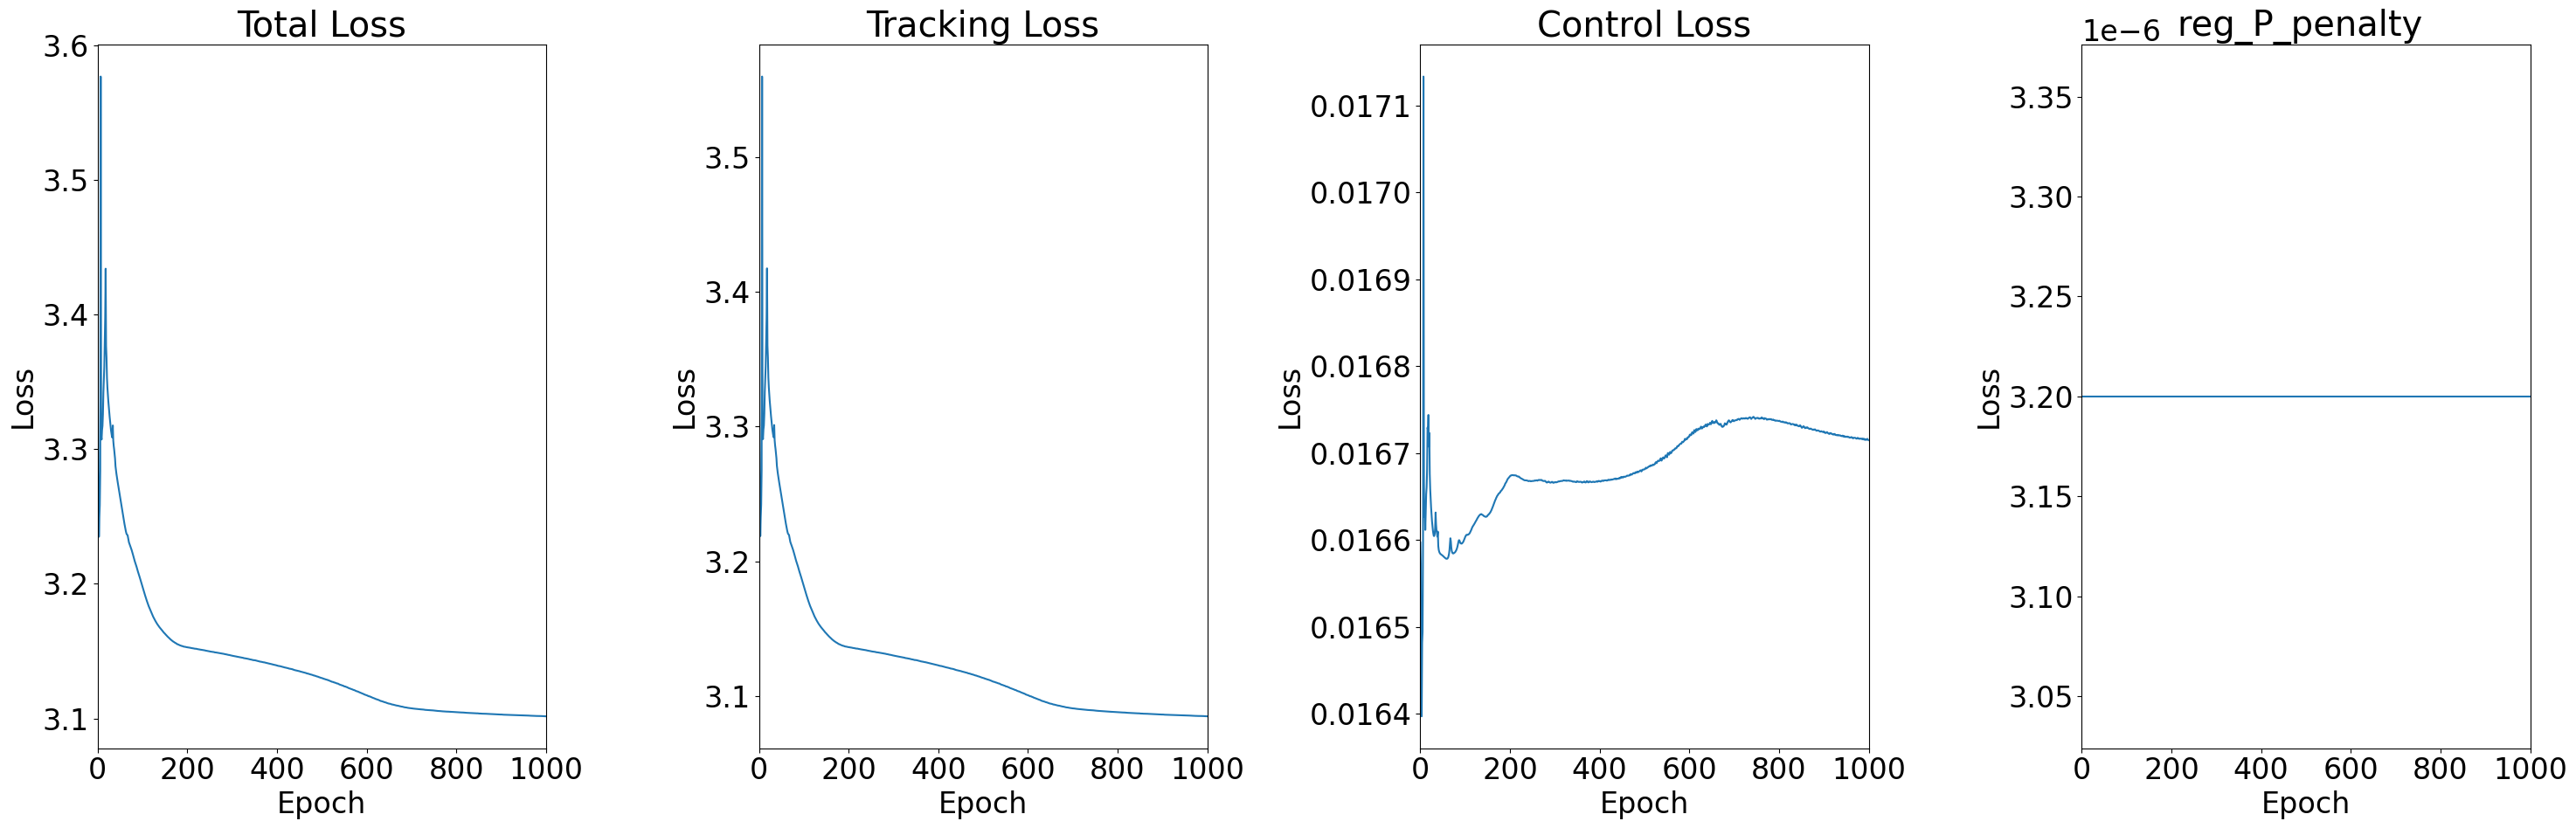

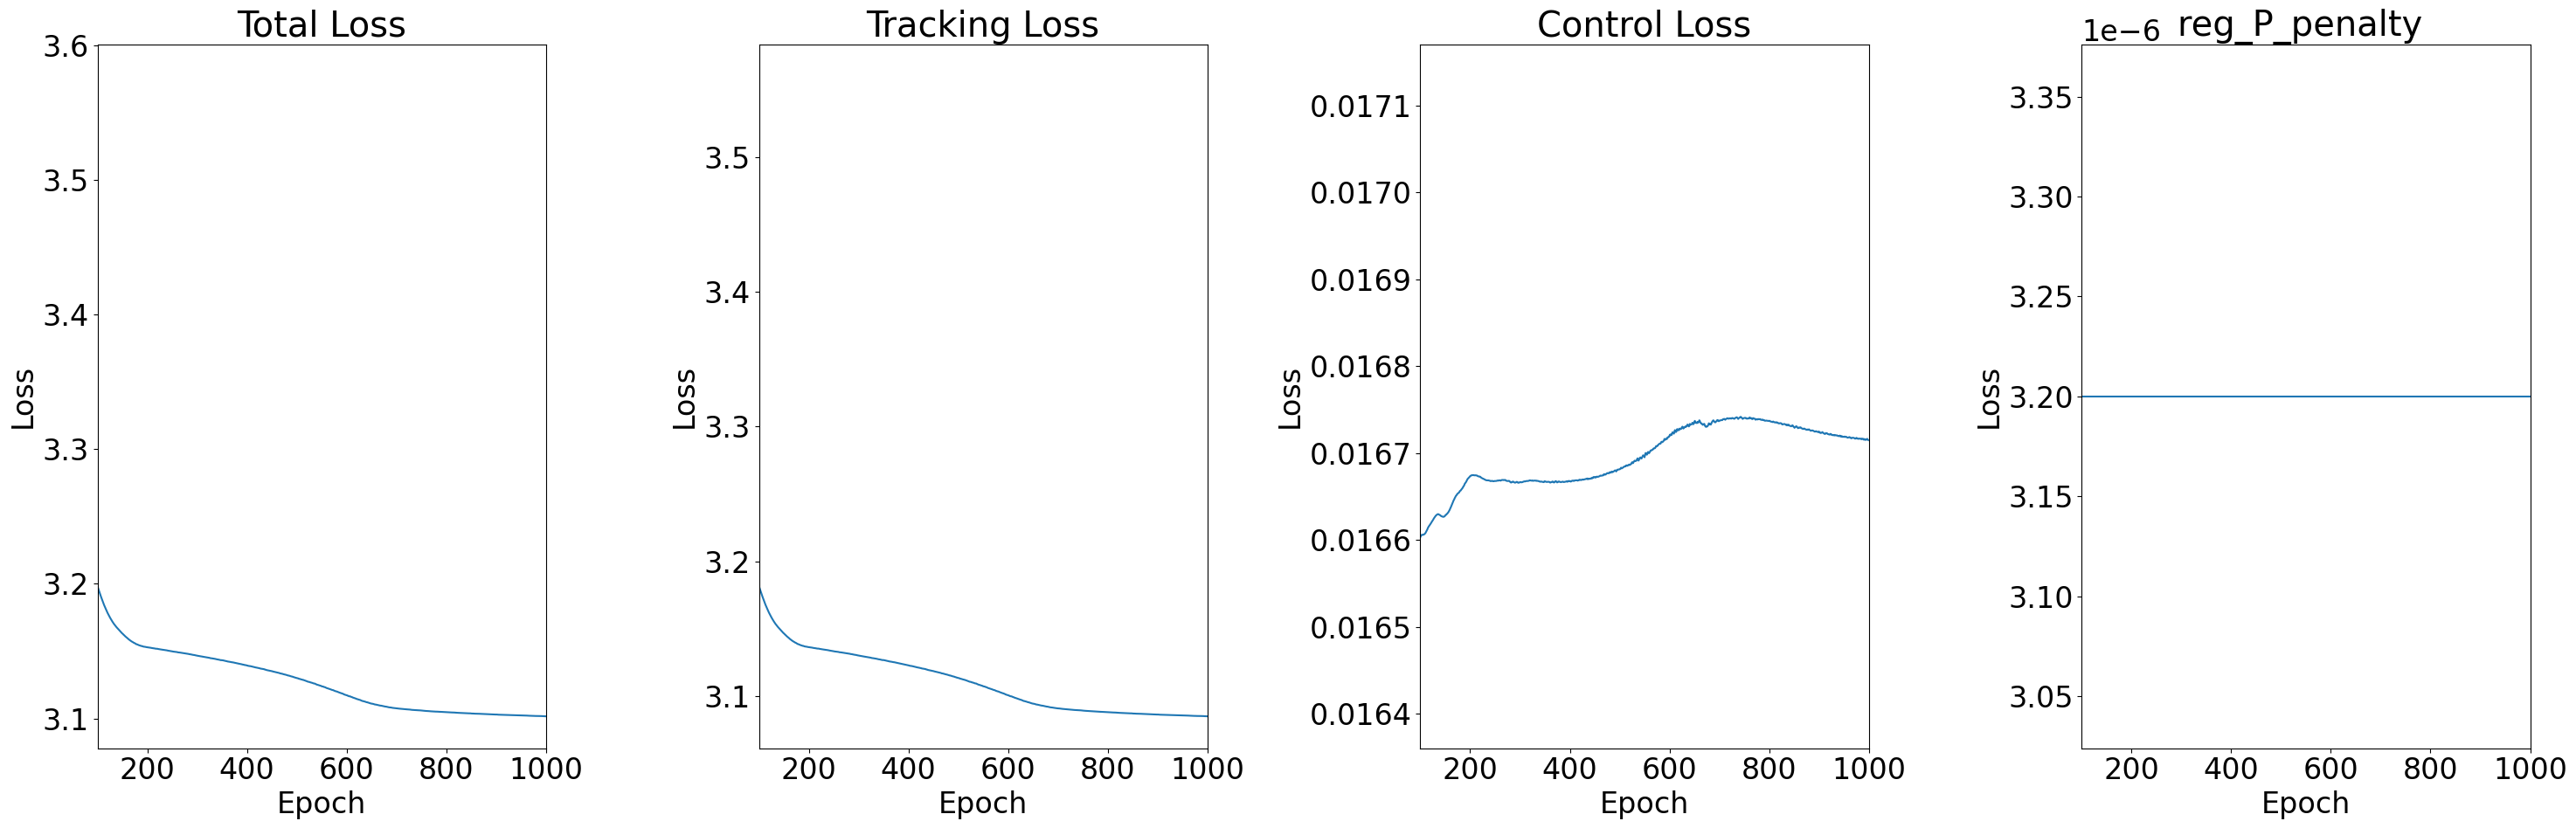

In [81]:
def plot_losses(raw, xlim=[0, int(raw['hparams']['ensemble']['num_epochs'])]):
    total_losses = []
    tracking_losses = []
    control_losses = []
    reg_P_penalties = []
    E = int(raw['hparams']['ensemble']['num_epochs'])
    for epoch_i in range(E):
        total_losses.append(validate_model(raw, epoch_i, plot=False)[0])
        tracking_losses.append(validate_model(raw, epoch_i, plot=False)[1])
        control_losses.append(validate_model(raw, epoch_i, plot=False)[2])
        reg_P_penalties.append(validate_model(raw, epoch_i, plot=False)[3])
        # print(validate_model(raw, epoch_i, plot=False)[3])

    fig, ax = plt.subplots(1, 4, figsize=(30, 10))
    ax[0].plot(range(E), total_losses)
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].set_xlim(xlim)
    ax[0].set_title('Total Loss')

    ax[1].plot(range(E), tracking_losses)
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].set_xlim(xlim)
    ax[1].set_title('Tracking Loss')

    ax[2].plot(range(E), control_losses)
    ax[2].set_ylabel('Loss')
    ax[2].set_xlabel('Epoch')
    ax[2].set_xlim(xlim)
    ax[2].set_title('Control Loss')

    ax[3].plot(range(E), reg_P_penalties)
    ax[3].set_ylabel('Loss')
    ax[3].set_xlabel('Epoch')
    ax[3].set_xlim(xlim)
    ax[3].set_title('reg_P_penalty ')

    # print(total_losses[-1])
    # print(tracking_losses[-1])
    # print(control_losses[-1])
    # print(reg_P_penalties[-1])
    # fig.suptitle(f'Losses')
    fig.tight_layout()
    

plot_losses(raw)
plot_losses(raw, xlim=[100,int(raw['hparams']['ensemble']['num_epochs'])])